# FZD5

In [1]:
import gpsea
import hpotk

store = hpotk.configure_ontology_store()
hpo = store.load_minimal_hpo(release='v2023-10-09')
print(f'Loaded HPO v{hpo.version}')
print(f"Using gpsea version {gpsea.__version__}")

Loaded HPO v2023-10-09
Using gpsea version 0.7.1


### FZD5
We user the [Matched Annotation from NCBI and EMBL-EBI (MANE)](https://www.ncbi.nlm.nih.gov/refseq/MANE/) transcript and the corresponding protein identifier for FZD5.

In [2]:
gene_symbol = 'FZD5'
mane_tx_id = 'NM_003468.4'
mane_protein_id = 'NP_065979.1' # zinc finger SWIM domain-containing protein 6"

In [6]:
from ppktstore.registry import configure_phenopacket_registry
from gpsea.preprocessing import configure_caching_cohort_creator, load_phenopackets, load_phenopacket_folder

phenopacket_registry = configure_phenopacket_registry()
with phenopacket_registry.open_phenopacket_store('0.1.20') as ps:
        phenopackets = tuple(ps.iter_cohort_phenopackets(gene_symbol))


cohort_creator = configure_caching_cohort_creator(hpo)
cohort, qc_results = load_phenopackets(  
    phenopackets=phenopackets,
    cohort_creator=cohort_creator,
)
fz_dir = "../../../phenopacket-store/notebooks/FZD5/phenopackets"
cohort, qc_results  = load_phenopacket_folder(pp_directory=fz_dir, cohort_creator=cohort_creator)

qc_results.summarize()

Individuals Processed: 100%|██████████| 28/28 [00:00<00:00, 2405.48individuals/s]
Individuals Processed: 32individuals [00:00, 1382.78individuals/s]
Validated under permissive policy
No errors or warnings were found


In [7]:
from gpsea.view import CohortViewer

cv = CohortViewer(hpo)
cv.process(cohort, transcript_id=mane_tx_id)

HPO Term,ID,Seen in n individuals
Iris coloboma,HP:0000612,19
Nystagmus,HP:0000639,10
Chorioretinal coloboma,HP:0000567,9
Retinal coloboma,HP:0000480,8
Optic disc hypoplasia,HP:0007766,7
Optic disc coloboma,HP:0000588,7
Reduced visual acuity,HP:0007663,6
High myopia,HP:0011003,6
High hypermetropia,HP:0008499,3
Microphthalmia,HP:0000568,2


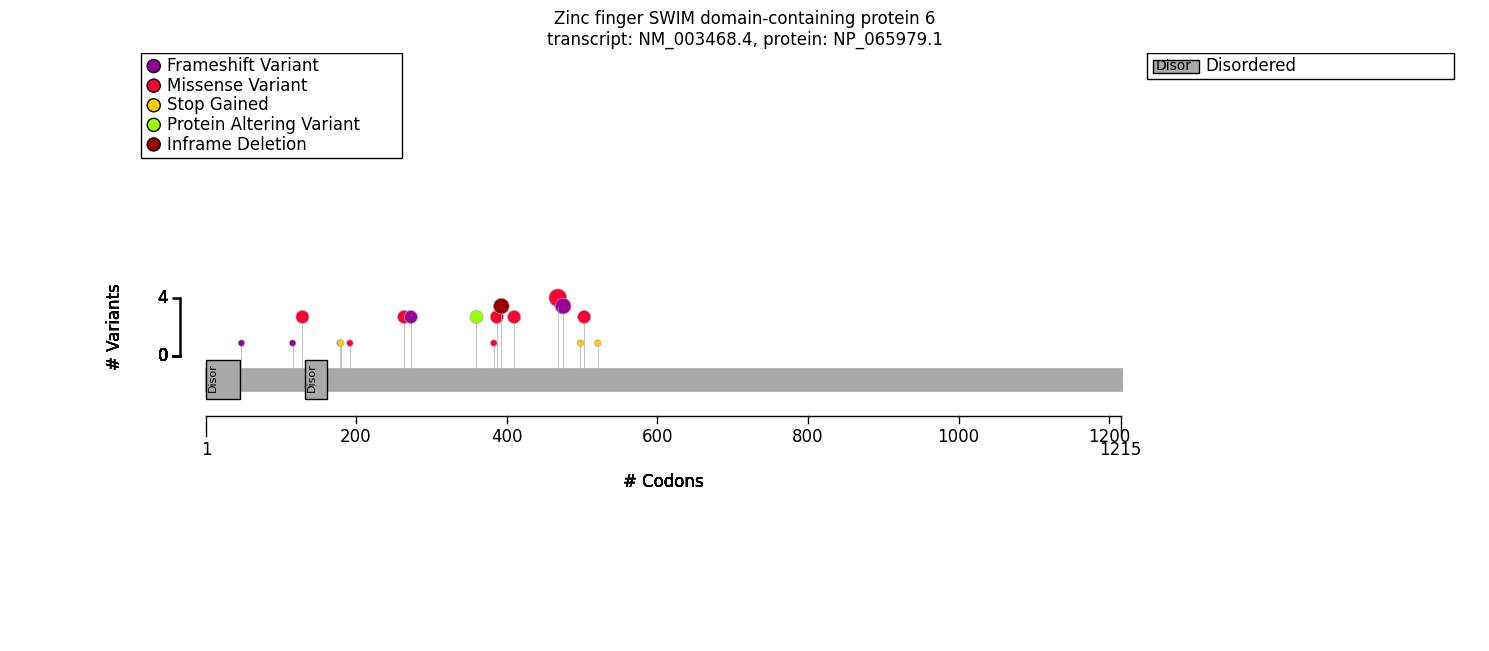

In [8]:
from gpsea.model.genome import GRCh38
from gpsea.model import ProteinMetadata
from gpsea.preprocessing import configure_default_protein_metadata_service, VVMultiCoordinateService
from gpsea.view import ProteinVisualizer
import matplotlib.pyplot as plt

txc_service = VVMultiCoordinateService(genome_build=GRCh38)
pms = configure_default_protein_metadata_service()
tx_coordinates = txc_service.fetch(mane_tx_id)
protein_meta = pms.annotate(mane_protein_id)

fig, ax = plt.subplots(figsize=(15, 8))
visualizer = ProteinVisualizer()
visualizer.draw_protein_diagram(
    tx_coordinates,
    protein_meta,
    cohort,
    ax=ax,
)
fig.tight_layout()

In [10]:
from gpsea.analysis.predicate.phenotype import prepare_predicates_for_terms_of_interest

pheno_predicates = prepare_predicates_for_terms_of_interest(
    cohort=cohort,
    hpo=hpo,
)

from gpsea.analysis.mtc_filter import HpoMtcFilter
mtc_filter = HpoMtcFilter.default_filter(
    hpo=hpo,
    term_frequency_threshold=0.1,
)
mtc_correction = 'fdr_bh'
mtc_alpha = 0.05
from gpsea.analysis.pcats.stats import FisherExactTest

count_statistic = FisherExactTest()
from gpsea.analysis.pcats import HpoTermAnalysis

analysis = HpoTermAnalysis(
    count_statistic=count_statistic,
    mtc_filter=mtc_filter,
    mtc_correction=mtc_correction,
    mtc_alpha=mtc_alpha,
)

In [12]:
from gpsea.model import VariantEffect
from gpsea.analysis.predicate.genotype import VariantPredicates, monoallelic_predicate

missense = VariantPredicates.variant_effect(VariantEffect.MISSENSE_VARIANT, tx_id=mane_tx_id)


gt_predicate = monoallelic_predicate(a_predicate=missense, b_predicate=~missense, a_label="missense", b_label="other")


In [13]:
result = analysis.compare_genotype_vs_phenotypes(
    cohort=cohort,
    gt_predicate=gt_predicate,
    pheno_predicates=pheno_predicates,
)
from gpsea.view import MtcStatsViewer

viewer = MtcStatsViewer()
viewer.process(result)

Code,Reason,Count
HMF02,Skipping term because no genotype has more than one observed HPO count,2
HMF08,Skipping general term,15
HMF09,Skipping term with maximum annotation frequency that was less than threshold 0.4,27


In [14]:
from gpsea.view import summarize_hpo_analysis

summarize_hpo_analysis(hpo=hpo, result=result)

Allele group                                 missense          other          \
                                                Count Percent  Count Percent   
Iris coloboma [HP:0000612]                       4/13     31%  15/19     79%   
Retinal coloboma [HP:0000480]                     2/8     25%    6/9     67%   
Optic disc coloboma [HP:0000588]                  0/3      0%   7/12     58%   
Strabismus [HP:0000486]                          0/13      0%   2/13     15%   
Optic disc hypoplasia [HP:0007766]                5/8     62%    2/6     33%   
Coloboma [HP:0000589]                             5/5    100%  17/17    100%   
Abnormality iris morphology [HP:0000525]          4/4    100%  15/15    100%   
Chorioretinal coloboma [HP:0000567]               2/3     67%   7/12     58%   
Abnormal fundus morphology [HP:0001098]         10/10    100%  18/18    100%   
Abnormal retinal morphology [HP:0000479]          5/5    100%  12/12    100%   
Abnormal optic nerve morphology [HP:0000587]      5/5    100%    9/9    100%   
Reduced visual acuity [HP:0007663]                4/8     50%    2/5     40%   
Nystagmus [HP:0000639]                           4/13     31%   6/17     35%   
High myopia [HP:0011003]                          2/7     29%   4/10     40%   

Allele group                                                               
                                             Corrected p values  p values  
Iris coloboma [HP:0000612]                             0.150902  0.010779  
Retinal coloboma [HP:0000480]                          0.933333  0.153435  
Optic disc coloboma [HP:0000588]                       0.933333  0.200000  
Strabismus [HP:0000486]                                1.000000  0.480000  
Optic disc hypoplasia [HP:0007766]                     1.000000  0.592075  
Coloboma [HP:0000589]                                  1.000000  1.000000  
Abnormality iris morphology [HP:0000525]               1.000000  1.000000  
Chorioretinal coloboma [HP:0000567]                    1.000000  1.000000  
Abnormal fundus morphology [HP:0001098]                1.000000  1.000000  
Abnormal retinal morphology [HP:0000479]               1.000000  1.000000  
Abnormal optic nerve morphology [HP:0000587]           1.000000  1.000000  
Reduced visual acuity [HP:0007663]                     1.000000  1.000000  
Nystagmus [HP:0000639]                                 1.000000  1.000000  
High myopia [HP:0011003]                               1.000000  1.000000